In [1]:
import arff
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from operator import attrgetter, itemgetter
from io import StringIO
from sklearn.model_selection import train_test_split
import nltk
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer, confusion_matrix,classification_report,precision_recall_fscore_support as score, average_precision_score
from sklearn import metrics
from sklearn.model_selection import cross_validate

## training model
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# Importing dataset

In [2]:
data = arff.load(open('../OffComBR3.arff'))
df = pd.DataFrame(data['data'])
df.columns = ['hate', 'sentence']

# transforming 'yes' into 1 and 'no' into 0
df['hate'] = df['hate'].apply(lambda x: 1 if x == 'yes' else 0)

X = df['sentence'].tolist()
y = df['hate'].tolist()
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, test_size=0.33, random_state=42)

In [3]:
cl =  Pipeline([
        ('tfidf',TfidfVectorizer( ngram_range=(1,4))),
        ('clf', RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0,)),
        ])

In [4]:
cl.fit(X_train, y_train)
pred = cl.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       267
           1       0.59      0.26      0.36        74

   micro avg       0.80      0.80      0.80       341
   macro avg       0.71      0.60      0.62       341
weighted avg       0.77      0.80      0.77       341



In [5]:
nltk.download('stopwords')
nltk.download('rslp')
stopwords = nltk.corpus.stopwords.words('portuguese')
stemmer = nltk.stem.RSLPStemmer()
nltk.download('punkt')


def clean_text(txt):
    text = ''
    for w in nltk.word_tokenize(txt):
        if w not in stopwords:
            text = text + stemmer.stem(w) + ' '
    return text.strip()

[nltk_data] Downloading package stopwords to /home/shivwa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /home/shivwa/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to /home/shivwa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
## Cleaning text before

for i in range(len(X_train)):
    n_txt = clean_text(X_train[i])
    X_train[i] = n_txt
    
for i in range(len(X_test)):
    n_txt = clean_text(X_test[i])
    X_test[i] = n_txt

In [7]:
cl.fit(X_train, y_train)
pred = cl.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.80      0.99      0.89       267
           1       0.77      0.14      0.23        74

   micro avg       0.80      0.80      0.80       341
   macro avg       0.79      0.56      0.56       341
weighted avg       0.80      0.80      0.74       341



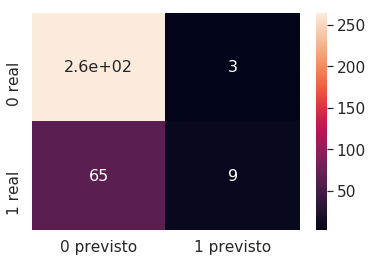

In [8]:
cm = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cm, ('0 real', '1 real'), ('0 previsto', '1 previsto'))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

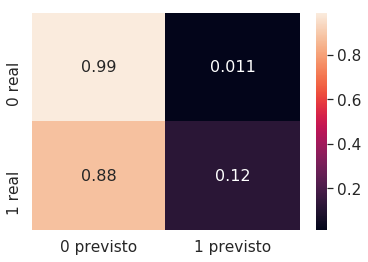

In [9]:
cm = confusion_matrix(y_test, pred)/ [[267,267],[74,74]] # deviding it by its real count so we can get the percentage
df_cm = pd.DataFrame(cm, ('0 real', '1 real'), ('0 previsto', '1 previsto'))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

## Usign K-FoldCV

In [9]:
def get_recal_1(y_true, y_pred):
    precision, recall, fscore, support = score(y_true, y_pred)
    print(classification_report(y_true, y_pred))
    return(recall[1])

In [10]:
data = arff.load(open('../OffComBR3.arff'))
df = pd.DataFrame(data['data'])
df.columns = ['hate', 'sentence']

# transforming 'yes' into 1 and 'no' into 0
df['hate'] = df['hate'].apply(lambda x: 1 if x == 'yes' else 0)

X = df['sentence'].tolist()
y = df['hate'].tolist()

for i in range(len(X)):
    X[i] = clean_text(X[i])

scores = cross_validate(cl, X, y,
                        cv=5, return_train_score=False, scoring=make_scorer(get_recal_1))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90       167
           1       0.75      0.15      0.24        41

   micro avg       0.82      0.82      0.82       208
   macro avg       0.79      0.57      0.57       208
weighted avg       0.81      0.82      0.77       208

              precision    recall  f1-score   support

           0       0.84      0.96      0.90       166
           1       0.65      0.27      0.38        41

   micro avg       0.83      0.83      0.83       207
   macro avg       0.74      0.62      0.64       207
weighted avg       0.80      0.83      0.80       207

              precision    recall  f1-score   support

           0       0.85      0.99      0.91       166
           1       0.91      0.25      0.39        40

   micro avg       0.85      0.85      0.85       206
   macro avg       0.88      0.62      0.65       206
weighted avg       0.86      0.85      0.81       206

              preci

## Grid tests with dynamic parameters

### Tests with accuracy as scoring paramether

In [11]:
## Teste com accuracy

parameters = {'tfidf__ngram_range': [(1,1), (1,2), (1,3), (1,4)],
              'clf__n_estimators': (10, 20, 100),
              'clf__max_depth': (None, 2, 10),
              'clf__min_samples_split': (2, 10),
              'clf__min_samples_leaf': (1, 10),
              'clf__min_weight_fraction_leaf': (0, 0.1, 0.5)
             }

gs_clf = GridSearchCV(cl, parameters, cv=5, iid=False, n_jobs=-1, scoring='accuracy')
# iidd: "If True, return the average score across folds, weighted by the number of samples"
# cv: Number of folds
# n_jobs: -1 means using all processors
# scoring: 'balanced accuracy is the average of recall obtained on each class.'

gs_clf.fit(X_train, y_train)
print(gs_clf.best_score_)
print(gs_clf.best_params_)

0.8482083644414204
{'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__min_weight_fraction_leaf': 0, 'clf__n_estimators': 100, 'tfidf__ngram_range': (1, 1)}


In [12]:
cl_enhanced =  Pipeline([
        ('tfidf',TfidfVectorizer(ngram_range=(1,4))),
        ('clf', SGDClassifier(alpha=0.01, loss='squared_hinge', penalty='none')),
        ])
cl_enhanced.fit(X_train, y_train)
pred = cl_enhanced.predict(X_test)
print(classification_report(y_test, pred))

NameError: name 'SGDClassifier' is not defined

### Tests with f1_macro as scoring paramether

In [ ]:
parameters = {'tfidf__ngram_range': [(1,1), (1,2), (1,3), (1,4)],
              'clf__alpha': (1, 1e-2),
              'clf__loss': ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'),
              'clf__penalty': ('none', 'l2', 'l1','elasticnet')
             }

gs_clf = GridSearchCV(cl, parameters, cv=5, iid=False, n_jobs=-1, scoring='f1_macro')

gs_clf.fit(X_train, y_train)
print(gs_clf.best_score_)
print(gs_clf.best_params_)

In [ ]:
cl_enhanced =  Pipeline([
        ('tfidf',TfidfVectorizer(ngram_range=(1,1))),
        ('clf', SGDClassifier(alpha=0.01, loss='modified_huber', penalty='none')),
        ])
cl_enhanced.fit(X_train, y_train)
pred = cl_enhanced.predict(X_test)
print(classification_report(y_test, pred))

### Tests with precision as scoring paramether

In [ ]:
parameters = {'tfidf__ngram_range': [(1,1), (1,2), (1,3), (1,4)],
              'clf__alpha': (1, 1e-2),
              'clf__loss': ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'),
              'clf__penalty': ('none', 'l2', 'l1','elasticnet')
             }

gs_clf = GridSearchCV(cl, parameters, cv=5, iid=False, n_jobs=-1, scoring='precision')

gs_clf.fit(X_train, y_train)
print(gs_clf.best_score_)
print(gs_clf.best_params_)

In [ ]:
cl_enhanced =  Pipeline([
        ('tfidf',TfidfVectorizer(ngram_range=(1,1))),
        ('clf', SGDClassifier(alpha=0.01, loss='modified_huber', penalty='l2')),
        ])
cl_enhanced.fit(X_train, y_train)
pred = cl_enhanced.predict(X_test)
print(classification_report(y_test, pred))

### Tests with recall as scoring paramether

In [ ]:
parameters = {'tfidf__ngram_range': [(1,1), (1,2), (1,3), (1,4)],
              'clf__alpha': (1, 1e-2),
              'clf__loss': ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'),
              'clf__penalty': ('none', 'l2', 'l1','elasticnet')
             }

gs_clf = GridSearchCV(cl, parameters, cv=5, iid=False, n_jobs=-1, scoring='recall')

gs_clf.fit(X_train, y_train)
print(gs_clf.best_score_)
print(gs_clf.best_params_)

In [ ]:
cl_enhanced =  Pipeline([
        ('tfidf',TfidfVectorizer(ngram_range=(1,3))),
        ('clf', SGDClassifier(alpha=0.01, loss='perceptron', penalty='none')),
        ])
cl_enhanced.fit(X_train, y_train)
pred = cl_enhanced.predict(X_test)
print(classification_report(y_test, pred))